## <span style="color:blue">G95 Summary Lac Léman</span>

### <span style="color:red">Narative not complete</span>

### <span style="color:#008891">Incidence of cotton swabs by location and significant values</span>


#### <span style="color:#008891">Definition of significant values</span>

#### <span style="color:#008891">National results: </span>

#### <span style="color:#008891">Lac Léman results</span>

#### <span style="color:#008891">Lac Léman G95 utilisation and availability </span>


questions or comments: analyst@hammerdirt.ch

In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt 
from statsmodels.distributions.empirical_distribution import ECDF


# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import seaborn as sns
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML

# mapping
import geopandas as gpd


# home brew utitilties
import utilities.utility_functions as ut

# documenting
from IPython.display import Markdown as md


# variables/arrays that are frequently used:
# project lakes
the_lakes = [
    "Bielersee",
    "Walensee",
    "Lac Léman",
    "Zurichsee",
    "Neuenburgersee",
    "Thunersee",
    "Lago Maggiore",
    "Brienzersee",
]

# standard formats already in use for charts, these will gradually
# define the chart style or output format for the app
# you can just apply these as kwargs to different elements...


# table kwargs
table_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=[.5, .5], cellLoc='center')
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center')
tabtickp_k = dict(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

# chart kwargs
title_k = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12}
title_k20 = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
title_k17 = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'salmon'}
titler_k20 = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
titler_k17 = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'salmon'}
xlab_k = {'labelpad':10, 'fontsize':12}
ylab_k = {'labelpad':14, 'fontsize':14}
titler_k = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12}

# use these to format date axis in charts
weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
days = mdates.DayLocator(bymonthday=1, interval=1)
months = mdates.MonthLocator(bymonth=[3,6,9,12])
wks_fmt = mdates.DateFormatter('%d')
mths_fmt = mdates.DateFormatter('%b')

# map marker size:
markerSize = 100

In [2]:
# the local file structure. The resources are located in the corresponding directory.
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

# set some parameters:
start_date = '2020-04-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d')
code = 'G95'
name = 'cotton swab'
lake = 'Lac Léman'

# define a significant event:
sig = .9
one_minus_sig = (1-sig)

name_of_project = 'g95Summary'

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# probably want to keep these... the works already done
# aggregated survey data
dfAgg = pd.read_csv(F"{survey_data}/results_with_zeroes_aggregated_parent.csv")
dfAgg = dfAgg[dfAgg.location != 'signalpain']
dfAgg['date'] = pd.to_datetime(dfAgg['date'])

# non aggregated survey data
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'])

# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
# dfSurveys = dfSurveys[dfSurveys.location != 'signalpain']
# dfBeaches = dfBeaches[dfBeaches.slug != 'signalpain']
dfBeaches.set_index('slug', inplace=True)

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv")

# geo data: explantory variables, index by slug and make a map:
dfStreets = pd.read_csv(F"{geo_data}/exp_variables/strasse_1000.csv", index_col='slug')['length']
dfBlds = pd.read_csv(F"{geo_data}/exp_variables/builds_500.csv", index_col='slug')['area']
dfRivs = dfBeaches['NUMPOINTS']

# restrict to lakes only
dfS = dfAgg.loc[(dfAgg.water_name.isin(the_lakes))&(dfAgg.date >= start_date)].copy()

# map geo values to survey results:
dfS['population']=dfS.location.map(lambda x: dfBeaches.loc[x]['population'])
dfS['streets'] = dfS.location.map(lambda x: dfStreets.loc[x])
dfS['buildings'] = dfS.location.map(lambda x: dfBlds.loc[x])
dfS['rivs'] = dfS.location.map(lambda x: dfRivs.loc[x])

# seperate out the codes of interest
dfCode = dfS.loc[dfS.code == code].copy()

# daily totals for each group, index to date
allDf = dfS.groupby(['loc_date','location','water_name', 'date','population','streets','buildings','rivs'], as_index=False).pcs_m.sum()
allDf.set_index('date', inplace=True)
dtotal = allDf.copy()

# key that to the loc_date
dtotal.set_index('loc_date', inplace=True)

# daily totals for the code of interest
g112Df = dfCode.groupby(['loc_date','location', 'water_name','date','population','streets','buildings','rivs'], as_index=False).pcs_m.sum()
g112Df.set_index('date', inplace=True)
g112Dt = g112Df.copy()

# key that to the loc_date
g112Dt.set_index('loc_date', drop=True, inplace=True)

# count the surveys with gpi for each lake
survWith = g112Dt[g112Dt.pcs_m > 0].groupby('water_name').count()

# get the % of total of gpi for each survey
g112Df['p_total'] = g112Df.loc_date.map(lambda x: g112Dt.loc[x].pcs_m/dtotal.loc[x].pcs_m)
g112Df['p_total'] = g112Df['p_total']*100
g112Df['p_total'] = g112Df['p_total'].round(2)

# make files for export:

# keep track of the files you are exporting:
files_generated = []


survey_csv = F"{project_directory}/survey_data.csv"
files_generated.append(survey_csv)
dfS.to_csv(survey_csv, index=False)

beaches_csv = F"{project_directory}/beach_data.csv"
files_generated.append(beaches_csv)
dfBeaches.to_csv(beaches_csv, index=False)


### <span style="color:#1e90ff">Methods</span>

#### **<span style="color:#008891">Data source, time frame, geographic scope and collection methods </span>**

The data for this analysis is the results from beach-litter surveys conducted in Switzerland from <span style="color:red">!! Put your dates here !! through January 18, 2021</span>.

All surveys that were conducted on Bielersee, Neuenburgersee, Thunersee, Walensee, Zurichsee, Lac Léman, Brienzersee and Lago Magiore were considered. 

The data was collected according to the protocol described here [https://www.plagespropres.ch/](https://www.plagespropres.ch/). In brief all visible data is collected along a beach within a measured distance from the waters edge. The width of the survey area depends on the terrain and the water level. The visible strand line or the nearest physical structure defines the width of a survey.

Surveys were conducted by the following organizations:

1. hammerdirt
2. Association pour le Sauvegarde du leman
3. Solid Waste Management Ecole Polytechnique Federal
4. Ecole International de Geneve
5. Precious plastic leman
6. Why isn't your association here?

This analysis is an open source document. The working note book is available in the repository located here [https://github.com/hammerdirt-analyst/iqals](https://github.com/hammerdirt-analyst/iqals).

**Francais**

Les données utilisées pour cette analyse sont les résultats d'enquêtes sur les déchets de plage menées en Suisse <span style="color:red">!! put your dates here !! du 1er avril 2020 au 28  janvier 2021</span>.

Toutes les enquêtes qui ont été menées sur le lac de Bienne, le lac de Neuchâtel, le lac de Thoune, le lac Walensee, le lac de Zurich, le lac Léman, le lac Brienzer et le lac Magiore ont été prises en compte. 

Les données ont été collectées selon le protocole décrit ici [https://www.plagespropres.ch/] (https://www.plagespropres.ch/). En bref, toutes les données visibles sont collectées le long d'une plage à une distance mesurée du bord de l'eau. La largeur de la zone d'étude dépend du terrain et du niveau de l'eau. La ligne de rive visible ou la structure physique la plus proche définit la largeur d'une enquête.

Des enquêtes ont été menées par:

1. hammerdirt
2. Association pour le Sauvegarde du leman
3. Solid Waste Management Ecole Polytechnique Federal
4. Ecole International de Geneve
5. Precious plastic leman
6. Why isn't your association here?1. hammerdirt

Cette analyse est un document open source. Le cahier de notes de travail est disponible dans le dépôt situé ici: [https://github.com/hammerdirt-analyst/iqals](https://github.com/hammerdirt-analyst/iqals).

#### <span style="color:#008891">Scope of surveys</span>

The scope of the surveys includes the total population levels and land use configuration for the adjacent municipality. Land use is quantified by calculating the m² of space attributed to buildings wtihin 500m of the survey location and the total length in meters of roads within 1000m of the survey location\*.

The results and survey locations can be classified according to the following attributes:

1. M² of buildings within 500m of the survey
2. Total length of streets/roads within 1000m of the survey
3. Number of river/canal intersections within 1500m of the survey
3. Population of the surounding municipality

\*Values are calculated using [https://shop.swisstopo.admin.ch/en/products/landscape/tlm3D](https://shop.swisstopo.admin.ch/en/products/landscape/tlm3D)

**Français**

Le champ d'application des enquêtes comprend les niveaux de population totale et la configuration de l'utilisation des sols pour la municipalité environante. L'utilisation des sols est quantifiée en calculant la superficie en m² attribuée aux bâtiments dans un rayon de 500 m du lieu de l'enquête et la longueur totale en mètres des routes dans un rayon de 1000 m du lieu de l'enquête\*.

Les résultats et les lieux d'enquête peuvent être classés selon les attributs suivants :

1. M² de surface au sol des bâtiments situés dans un rayon de 500m du lieu d'enquête
2. Longueur totale des rues/routes dans un rayon de 1000 m de l'enquête
3. Nombre d'intersections de rivières/canaux dans un rayon de 1500m de l'étude
3. Population de la commune environnante

Les valeurs sont calculées en utilisant  [https://shop.swisstopo.admin.ch/en/products/landscape/tlm3D](https://shop.swisstopo.admin.ch/en/products/landscape/tlm3D)

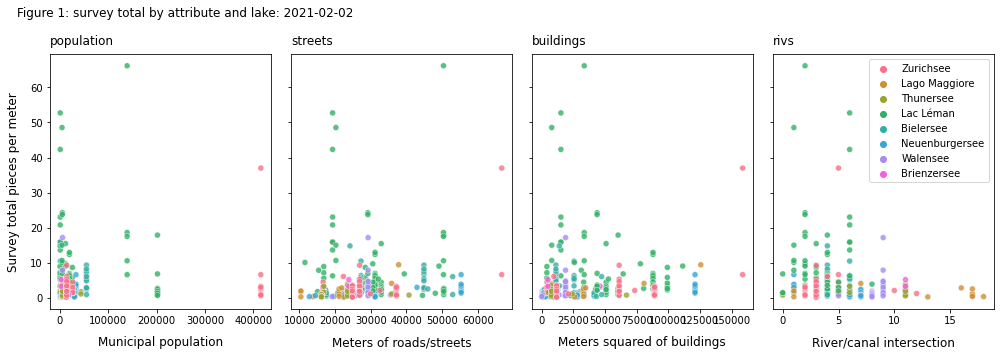

In [3]:
# figure one total survey pcs/m per attribute value:

fig, axs = plt.subplots(1,4, figsize=(14,5), sharey=True)

# key the column names to appropriate chart titles:
titles_text = {
    'population':'Municipal population',
    'streets': 'Meters of roads/streets',
    'buildings':'Meters squared of buildings',
    'rivs':'River/canal intersection',
    
}

# produce a chart for each explanatory variable
for i, att in enumerate(['population','streets','buildings','rivs']):
    data = dtotal[['water_name','pcs_m', att]]
    ax = sns.scatterplot(data=data, x=att, y='pcs_m', hue='water_name', palette='husl', alpha=0.8, ax=axs[i])
    axs[i].set_title(att, **title_k)
    axs[i].set_xlabel(titles_text[att], **xlab_k)
    axs[i].set_ylabel('')
    axs[i].get_legend().remove()
axs[0].set_ylabel('Survey total pieces per meter', **xlab_k)

handles, labels =  ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.suptitle(F"Figure 1: survey total by attribute and lake: {end_date}", x=0.02, y=0.98, ha='left')

# save that
figureonefile = F"{project_directory}/figureone.jpg"
files_generated.append(figureonefile)
plt.savefig(figureonefile, dpi=300)


plt.tight_layout()
plt.show()
plt.close()

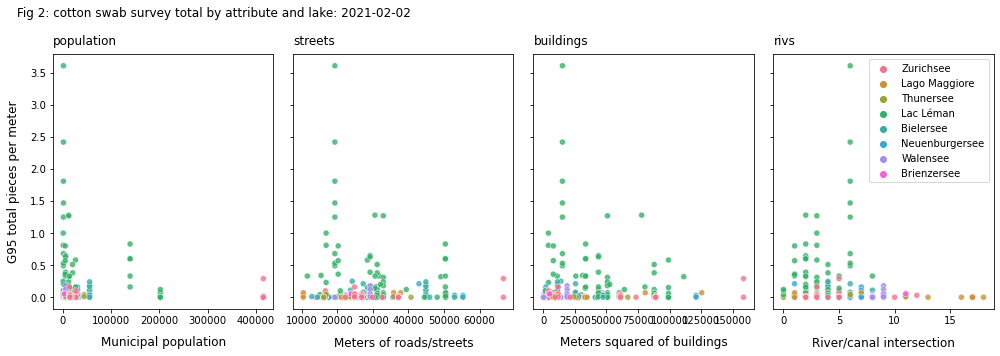

In [4]:
# figure two total code pcs/m per attribute value:

fig, axs = plt.subplots(1,4, figsize=(14,5), sharey=True)

for i, att in enumerate(['population','streets','buildings','rivs']):
    data = g112Dt[['water_name','pcs_m', att]]
    ax = sns.scatterplot(data=data, x=att, y='pcs_m', hue='water_name', palette='husl', alpha=0.8, ax=axs[i])
    axs[i].set_title(att, **title_k)
    axs[i].set_xlabel(titles_text[att], **xlab_k)
    axs[i].set_ylabel('')
    axs[i].get_legend().remove()
axs[0].set_ylabel(F"{code} total pieces per meter", **xlab_k)

handles, labels =  ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.suptitle(F"Fig 2: {name} survey total by attribute and lake: {end_date}", x=0.02, y=0.98, ha='left')

figuretwofile = F"{project_directory}/figuretwo.jpg"
files_generated.append(figuretwofile)
plt.savefig(figuretwofile, dpi=300)

plt.tight_layout()
plt.show()
plt.close()

In [5]:
# calculator: what ever other metric that needs to be calculated
# shoud be calculated here. Then they can be used in the narrative
# or applied to the regional results. Good place to look at
# correlation tables with geo data

# group by location and get the total found
qGpi = dfCode.groupby(['location', 'water_name'], as_index=False).quantity.sum()

# seperate locations with or wothout the code
noGpi = qGpi[qGpi.quantity == 0]
hasGpi = qGpi[qGpi.quantity > 0]

# count the number of locations with the code value per lake
lakes_with = hasGpi[['water_name', 'location']].groupby(['water_name']).nunique('location')

# total gpi found and percent of total
numg112 = dfS[dfS.code == code].quantity.sum()
numtotal = dfS.quantity.sum()
g112_p_total = numg112/numtotal

# Frequency, surveys with code 
qGpiD = dfCode.groupby(['location', 'water_name','loc_date', 'date'], as_index=False).pcs_m.sum()
number_trys = len(qGpiD)
number_fail = sum(qGpiD.pcs_m == 0)
number_succ = len(qGpiD[qGpiD.pcs_m > 0])
# print("CODE total values")
# print(numg112)
# print(numtotal)
# print(g112_p_total)

# print("CODE trys and fails")
# print(number_trys)
# print(number_fail)
# print(number_succ)

# correlation with geo variables

# g112Df[['population', 'streets', 'buildings', 'rivs', 'pcs_m', ]].corr('spearman')

#### <span style="color:#008891">Geographic scope of surveys</span>

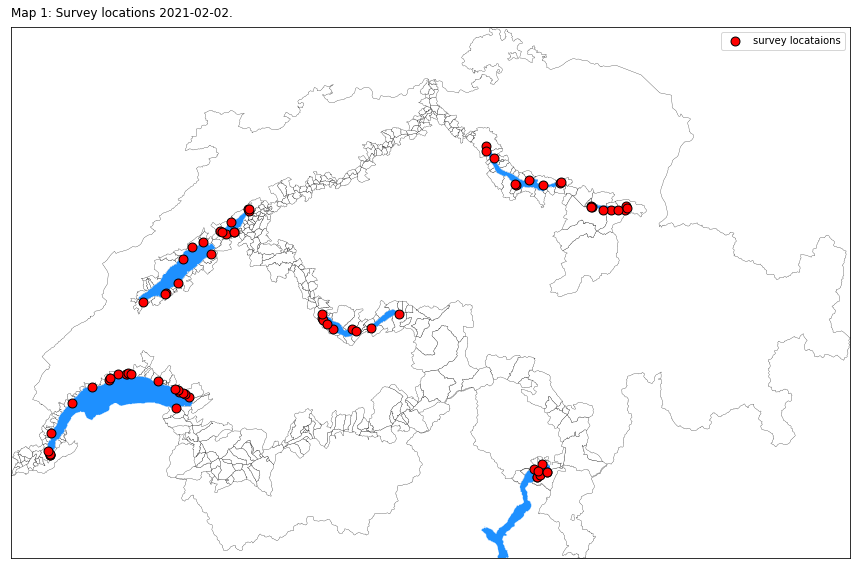

In [6]:
# import shapes
gdf = gpd.read_file('resources/shapes/riparian_communities.shp')
gdfch = gpd.read_file('resources/shapes/ch.shp')
gdflakes = gpd.read_file('resources/shapes/project_lakes.shp')

# make point layers, add survey results

# get the beaches from the location column of the data
beaches = dfBeaches.loc[dfBeaches.index.isin(dtotal.location.unique())].copy()

# create map the median pcs/m to location
median_map = dtotal.groupby('location').pcs_m.median().copy()

# apply the map to the beach data:
beaches['pcs_m'] = beaches.index.map(lambda x: median_map[x])

# port to gpd and reproject to the correct crs:
gbeaches = gpd.GeoDataFrame(beaches, crs='EPSG:4326', geometry=gpd.points_from_xy(beaches.longitude, beaches.latitude))
gdbeaches = gbeaches.to_crs(gdf.crs)

fig, axs = plt.subplots(figsize=(12,12))
axs.set_aspect('equal')

# plot the shapes and points:
gdfch.plot(ax=axs, zorder=0, color='white', edgecolor='black', linewidth=0.26)
gdf.plot(ax=axs, zorder=1, color='white', edgecolor='black', label='riparian coumminities', linewidth=0.26)
gdflakes.plot(ax=axs, zorder=2, color='dodgerblue', edgecolor='white', linewidth=0.26)
gdbeaches.plot(ax=axs, zorder=3, color='red', edgecolor='black',marker='o', label='survey locataions',  markersize=80)

# get and set the bounds
minx, miny, maxx, maxy = gdfch.total_bounds
axs.set_xticks([])
axs.set_yticks([])
axs.set_title(F"Map 1: Survey locations {end_date}.", **title_k)
axs.set_xlim(minx, maxx)
axs.set_ylim(miny, maxy)

handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)
plt.tight_layout()

maponefile = F"{project_directory}/mapone.jpg"
files_generated.append(maponefile)
plt.savefig(maponefile, dpi=300)

plt.show()
plt.close()

### <span style="color:#1e90ff">Survey results</span>
(table 1)

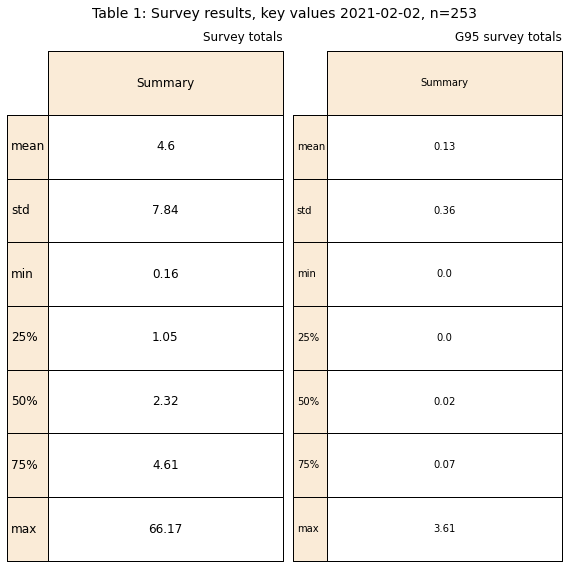

In [7]:
# make summary of data and put to table:

# summarize the total pcs/m per survey:
# use pd.describe and omit the first element (count):
dtotal_summary = [[np.round(dtotal.pcs_m.describe()[i], 2)] for i in dtotal.pcs_m.describe().index[1:]]
# use the index for the row labels:
dtotal_rowlabels=dtotal.pcs_m.describe().index[1:]

# repeat for the code of interest
g112Dt_summary = [[np.round(g112Dt.pcs_m.describe()[i], 2)] for i in g112Dt.pcs_m.describe().index[1:]]
g112Dt_rowlabels=g112Dt.pcs_m.describe().index[1:]

fig, axs = plt.subplots(1,2, figsize=(8,8))

anax = axs[0].add_table(mpl.table.table(cellText=dtotal_summary,rowLabels=dtotal_rowlabels, colLabels=['Summary'],colColours=['antiquewhite' for i in np.arange(1)], rowColours=['antiquewhite' for i in np.arange(len(dtotal_rowlabels))],  ax=axs[0], **tablecenter_k))
anax.set_fontsize(12)
axs[0].grid(False)

# this removes the frames around the plot area
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].spines["left"].set_visible(False)
axs[0].tick_params(**tabtickp_k)
axs[0].set_title(F"Survey totals", **titler_k)


anax1 = axs[1].add_table(mpl.table.table(cellText=g112Dt_summary,rowLabels=g112Dt_rowlabels, colLabels=['Summary'],colColours=['antiquewhite' for i in np.arange(1)], rowColours=['antiquewhite' for i in np.arange(len(g112Dt_rowlabels))],  ax=axs[1], **tablecenter_k))
anax.set_fontsize(12)
axs[1].grid(False)

# this removes the frames around the plot area
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["bottom"].set_visible(False)
axs[1].spines["left"].set_visible(False)
axs[1].tick_params(**tabtickp_k)
axs[1].set_title(F"{code} survey totals", **titler_k)

plt.suptitle(F"Table 1: Survey results, key values {end_date}, n={len(g112Dt)}", x=.5, y=0.98, ha='center', fontsize=(14))

tableonefile = F"{project_directory}/tableone.jpg"
files_generated.append(tableonefile)
plt.savefig(tableonefile, dpi=300)

plt.tight_layout()
plt.box(on=None)
plt.show()
plt.close()

### <span style="color:#008891">Regional summary</span>

(table 2).

In [8]:
# summarize the results by lake.
# Number of locations and surveys with or without code for each lake
# Make column headers plain english, make table

# aggregating some of the values
regional_summary = g112Df.groupby('water_name').agg({'loc_date':'count', 'location':'nunique', 'pcs_m':'median', 'p_total':'mean'})
# the mean of all the data
rs_mean = g112Df.groupby('water_name').pcs_m.mean()

# the number of samples with code > 0
# maps to survWith
regional_summary[F"# samps {code}"] = regional_summary.index.map(lambda x: F"{survWith.loc[x].pcs_m}/{g112Df[g112Df.water_name == x].loc_date.nunique()}")
# the number of locations with code > 0
# maps to lakes_with
regional_summary['locations with'] = regional_summary.index.map(lambda x: F"{lakes_with.loc[x].location}/{regional_summary.loc[x].location}")
regional_summary.rename(columns={'loc_date':'# samples',"locations with":F"# with {code}",  'location':'# locations', "pcs_m":"median pcs/m","p_total":"% of daily total"}, inplace=True)
# add the pcs/m per region:
regional_summary['mean pcs/m'] = regional_summary.index.map(lambda x: rs_mean[x])
regional_summary = regional_summary[["# locations", F"# with {code}","# samples", F"# samps {code}", "median pcs/m", "mean pcs/m", "% of daily total"]]

# reset the index, we need the index for a column in the table
regional_summary.reset_index(inplace=True)

# make a column name for the former index:
regional_summary.rename(columns={'water_name':'lake'}, inplace=True)

# round any values:
regional_summary['mean pcs/m'] = regional_summary['mean pcs/m'].round(3)
regional_summary["median pcs/m"] = regional_summary["median pcs/m"].round(3)
regional_summary["% of daily total"] = regional_summary["% of daily total"].round(2)

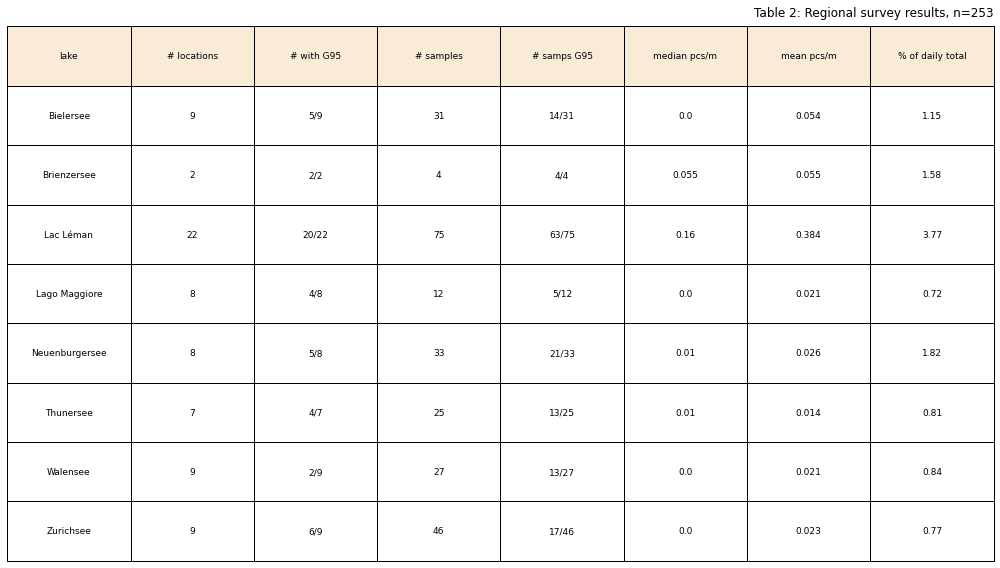

In [9]:
# call .values on the summary data
data = regional_summary.values

# adjust table args if need:
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center', fontsize=12)

fig, axs = plt.subplots(figsize=(14,8))

anax = axs.add_table(mpl.table.table(cellText=data, colLabels=regional_summary.columns,colColours=['antiquewhite' for col in regional_summary.columns], ax=axs, **tablecenter_k))
anax.set_fontsize(12)
axs.grid(False)
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
axs.spines["bottom"].set_visible(False)
axs.spines["left"].set_visible(False)
axs.tick_params(**tabtickp_k)
axs.set_title(F"Table 2: Regional survey results, n={len(g112Dt)}", **titler_k)

tabletwofile = F"{project_directory}/tabletwo.jpg"
files_generated.append(tabletwofile)
plt.savefig(tabletwofile, dpi=300)

plt.tight_layout()
plt.box(on=None)
plt.show()
plt.close()

### <span style="color:#008891">Distribution of survey results</span>
(fig 3).

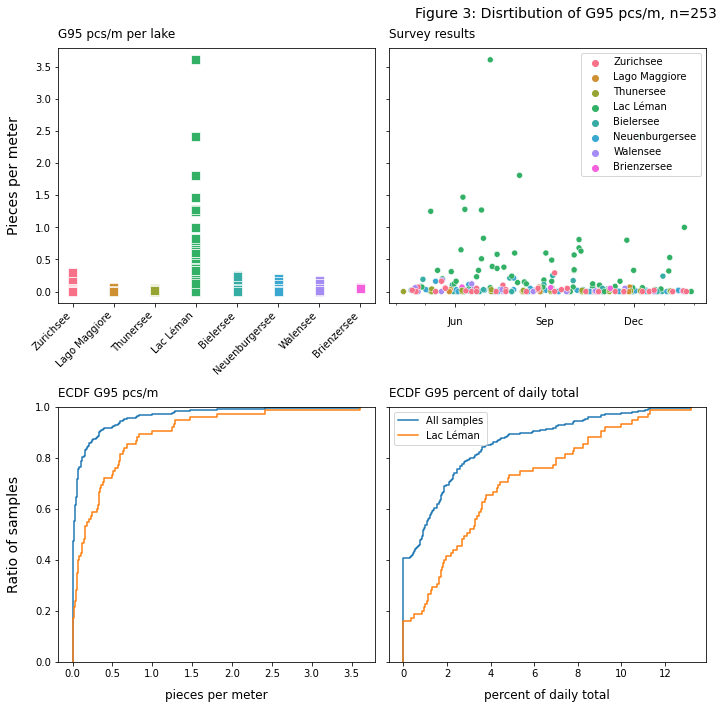

In [10]:
fig, axs = plt.subplots(2,2, figsize=(10,10), sharey='row')

# results by lake
ax = sns.scatterplot(data=g112Df, x='water_name',  y='pcs_m', hue='water_name', marker="s", s=80, palette='husl', ax=axs[0,0])
ax.xaxis.set_tick_params(rotation=45)
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")
ax.set_xlabel("")
ax.set_ylabel("Pieces per meter", **ylab_k)
ax.get_legend().remove()
ax.set_title(F"{code} pcs/m per lake", **title_k)

# results by date
ax2 = sns.scatterplot(data=g112Df, x='date', y='pcs_m', hue='water_name', palette='husl', ax=axs[0,1])
ax2.set_title("Survey results", **title_k)
ax2.xaxis.set_minor_locator(days)
ax2.xaxis.set_major_formatter(mths_fmt)
ax2.xaxis.set_major_locator(months)
ax2.tick_params(which='major', pad=10)
ax2.set_xlabel("")
labels, handles = ax2.get_legend_handles_labels()
ax2.legend(labels, handles)

# cumulative dist of pcs/m all-lakes and lake
ax3 = sns.ecdfplot(data=g112Df, x='pcs_m', label='All samples',ax=axs[1,0])
sns.ecdfplot(data=g112Df[g112Df.water_name == lake], x='pcs_m', label=lake, ax=axs[1,0])
ax3.set_title(F"ECDF {code} pcs/m", **title_k)
ax3.set_xlabel("pieces per meter", **xlab_k)
ax3.set_ylabel("Ratio of samples", **ylab_k)

# cumulative dist of percent of daily total all-lakes and lake
ax4 = sns.ecdfplot(data=g112Df, x='p_total',label='All samples', ax=axs[1,1])
ax4 = sns.ecdfplot(data=g112Df[g112Df.water_name == lake], x='p_total', label=lake,  ax=axs[1,1])
ax4.set_title(F"ECDF {code} percent of daily total", **title_k)
ax4.set_xlabel("percent of daily total", **xlab_k)
ax4.set_ylabel("Ratio of samples", **ylab_k)
labels, handles = ax4.get_legend_handles_labels()
ax4.legend(labels, handles)


plt.suptitle(F"Figure 3: Disrtibution of {code} pcs/m, n={len(g112Dt)}", x=1, y=0.98, ha='right', fontsize=(14))
plt.tight_layout()

figthreefile = F"{project_directory}/figurethree.jpg"
files_generated.append(figthreefile)
plt.savefig(figthreefile, dpi=300)

plt.show()
plt.close()

### <span style="color:#008891">Definition of significant values</span>

Significant values are those survey values that are equal to or exceed the 90th percentile of all survey results for the defined code.

(table 3, fig 4).

In [11]:
# use the ECDF method from statsmodels to get the ecdf function for the two values of interest
# pieces per meter
ecdf = ECDF(g112Df.pcs_m)

# percent of total
ecdfp_t = ECDF(g112Df.p_total)

# map the survey results to the cumulative distribution (or 1-ecdf(x)):
g112Df['p_dt'] = g112Df.pcs_m.map(lambda x: 1-ecdf(x))
g112Df['p_pt'] = g112Df.p_total.map(lambda x: 1-ecdfp_t(x))

# select all the significant events
p_dt90_s = g112Df.loc[g112Df.p_dt <= one_minus_sig]

# count the number of significant events per lake
p_dt90 = g112Df[g112Df.p_dt <= one_minus_sig].groupby(['water_name'], as_index=False).loc_date.nunique()

# put that in terms of the number of surveys in that region
p_dt90['frequency'] = p_dt90.water_name.map(lambda x: (F"{p_dt90.loc[p_dt90.water_name == x]['loc_date'].values[0]}/{regional_summary.loc[regional_summary.lake == x]['# samples'].values[0]}"))
p_dt90.rename(columns={'loc_date':'# significant','water_name': 'lake'}, inplace=True)

# identify all records that are siginifigant:
g112Df['significant'] = g112Df.p_dt.map(lambda x: x <= one_minus_sig)

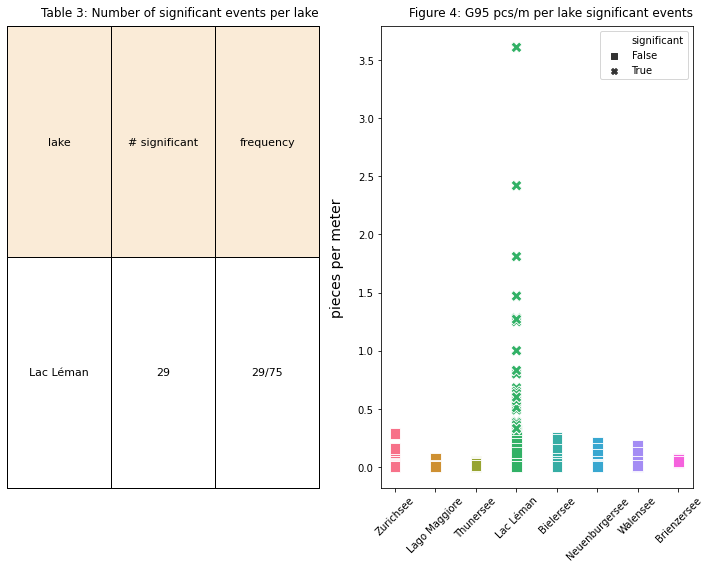

In [12]:
fig, axs = plt.subplots(1,2, figsize=(10,8))

# table of significant events
ax1 = axs[0].add_table(mpl.table.table(cellText=p_dt90.values, colLabels=p_dt90.columns,colColours=['antiquewhite' for col in p_dt90.columns], ax=axs[0], **tablecenter_k))
ax1.set_fontsize(12)
axs[0].grid(False)
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].spines["left"].set_visible(False)
axs[0].tick_params(**tabtickp_k)
axs[0].set_title(F"Table 3: Number of significant events per lake", **titler_k)

# significant events by lake
ax2 = sns.scatterplot(data=g112Df[g112Df.pcs_m < 10], x='water_name', y='pcs_m', hue='water_name', style='significant',s=120, ax=axs[1],palette='husl', markers={True:'X', False:'s'})
ax2.xaxis.set_tick_params(rotation=45)
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")
ax2.set_xlabel("")
ax2.set_ylabel("pieces per meter", **ylab_k)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[9:], labels[9:])
ax2.set_title(F"Figure 4: {code} pcs/m per lake significant events", **titler_k)

plt.tight_layout()
figfourfile = F"{project_directory}/figurefourtablethree.jpg"
files_generated.append(figfourfile)
plt.savefig(figfourfile,dpi=300)

plt.show()
plt.close()

In [13]:
ecdf_leman = ECDF(g112Df[g112Df.water_name == lake].pcs_m)
md(F"\nThe chance of finding AT LEAST one {code} for every 10 meters of survey nationally is: ~{np.round((1-ecdf(.1))*100, 1)}\n")


The chance of finding AT LEAST one G95 for every 10 meters of survey nationally is: ~22.5


In [14]:
md(F"\nThe chance of finding AT LEAST one {code} for every 10 meters of survey on Lac Léman is: ~{np.round((1-ecdf_leman(.1))*100, 1)}%\n")


The chance of finding AT LEAST one G95 for every 10 meters of survey on Lac Léman is: ~57.3%


In [15]:
# make the data for a map
# map median pcs_m to location
median_map = g112Df.groupby('location').pcs_m.median().copy()

# identify the beaches with no code:
noGpibeaches = dfBeaches.loc[dfBeaches.index.isin(noGpi.location.unique())].copy()
# apply the map
noGpibeaches['pcs_m'] = noGpibeaches.index.map(lambda x: median_map[x])

# repeat for the places where code was found:
gpbeaches = dfBeaches.loc[dfBeaches.index.isin(hasGpi.location.unique())].copy()
gpbeaches['pcs_m'] = gpbeaches.index.map(lambda x: median_map[x])

# repeat one more time for significant events:
gpsbeaches = dfBeaches.loc[dfBeaches.index.isin(p_dt90_s.location.unique())].copy()
gpsbeaches['pcs_m'] = gpsbeaches.index.map(lambda x: median_map[x])

# call gpd on datafarames
gbeaches = gpd.GeoDataFrame(noGpibeaches, crs='EPSG:4326', geometry=gpd.points_from_xy(noGpibeaches.longitude, noGpibeaches.latitude))
gpibeaches = gpd.GeoDataFrame(gpbeaches, crs='EPSG:4326', geometry=gpd.points_from_xy(gpbeaches.longitude, gpbeaches.latitude))
gpsigbeaches = gpd.GeoDataFrame(gpsbeaches, crs='EPSG:4326', geometry=gpd.points_from_xy(gpsbeaches.longitude, gpsbeaches.latitude))

# reproject to correct crs
gdbeaches = gbeaches.to_crs(gdf.crs)
gpibeaches = gpibeaches.to_crs(gdf.crs)
gpsigbeaches = gpsigbeaches.to_crs(gdf.crs)

### <span style="color:#008891">Geographic scope</span>

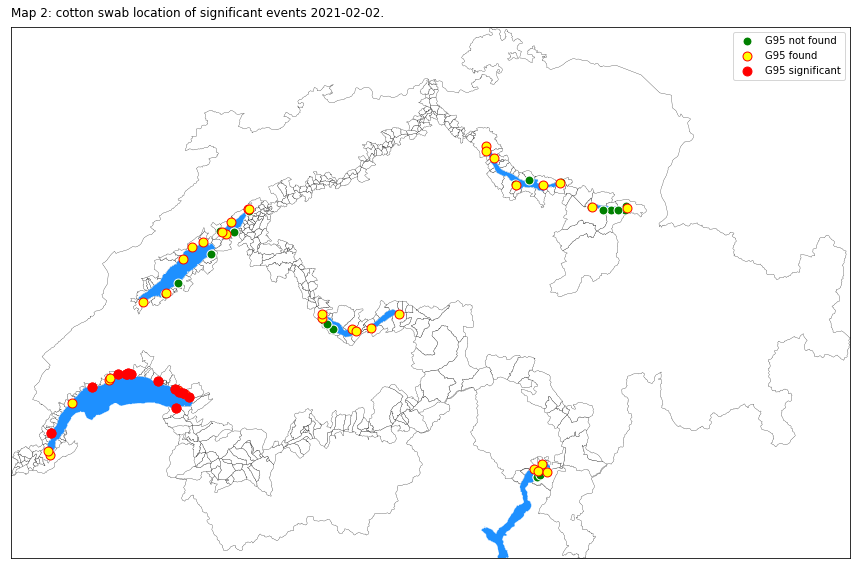

In [16]:
fig, axs = plt.subplots(figsize=(12,12))
axs.set_aspect('equal')

# plot the geo data
gdfch.plot(ax=axs, zorder=0, color='white', edgecolor='black', linewidth=0.26)
gdf.plot(ax=axs, zorder=1, color='white', edgecolor='black', label='riparian coumminities', linewidth=0.26)
gdflakes.plot(ax=axs, zorder=2, color='dodgerblue', edgecolor='white', linewidth=0.26)
gdbeaches.plot(ax=axs, zorder=3, color='green', edgecolor='white',marker='o', label=F"{code} not found", markersize=80)
gpibeaches.plot(ax=axs, zorder=3, color='yellow', edgecolor='red',marker='o', label=F"{code} found", markersize=80)
gpsigbeaches.plot(ax=axs, zorder=4, color='red', edgecolor='red',marker='o', label=F"{code} significant", markersize=80)

# get and set map bounds
minx, miny, maxx, maxy = gdfch.total_bounds
axs.set_xticks([])
axs.set_yticks([])
axs.set_title(F"Map 2: {name} location of significant events {end_date}.", **title_k)
axs.set_xlim(minx, maxx)
axs.set_ylim(miny, maxy)

handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)

plt.tight_layout()
maptwofile = F"{project_directory}/maptwo.jpg"
files_generated.append(maptwofile)
plt.savefig(maptwofile, dpi=300)

plt.show()
plt.close()

### <span style="color:#1e90ff">Lac Léman results and conclusions</span>
table 4, figure 5, table 5

In [17]:
# calculator: what ever other metric that needs to be calculated
# shoud be calculated here. Then they can be used in the narrative
# another good place to look at corelation at the lake level.

# get the data for the lake:
leman_data = dtotal[dtotal.water_name == lake]

# get the code results
lemang112 = g112Df.loc[g112Df.water_name == lake]

# get the surveys where at least one was found
leman_with = lemang112[lemang112.pcs_m > 0]
num_with = len(leman_with)

# get the quantities
leman_cdata = dfS[dfS.water_name == lake]
leman_tot = leman_cdata.quantity.sum()
leman_tg112 = leman_cdata[leman_cdata.code == code].quantity.sum()
# print(leman_tg112)
# print(leman_tot)
# print(leman_tg112/leman_tot)
# print(num_with)
# print(len(leman_data))
# print(lemang112.pcs_m.mean())
# print(lemang112.p_total.mean())

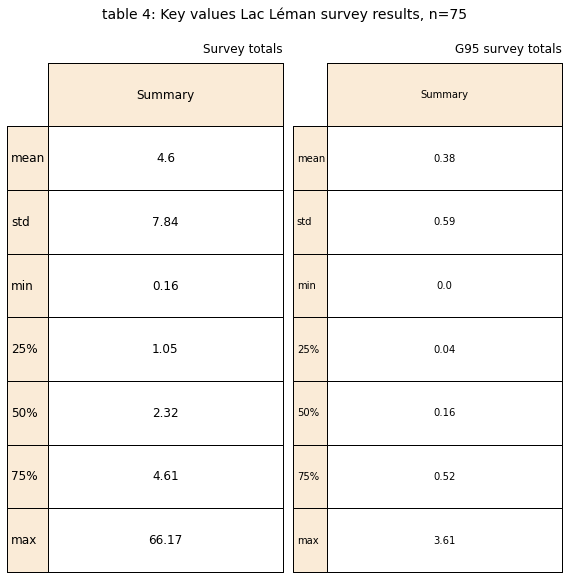

In [18]:
# make summary of data and put to table:

# summarize the total pcs/m per survey:
# use pd.describe and omit the first element (count):
leman_summary = [[np.round(leman_data.pcs_m.describe()[i], 2)] for i in leman_data.pcs_m.describe().index[1:]]
# use the index for the row labels:
dtotal_rowlabels=leman_data.pcs_m.describe().index[1:]

# repeat for the code o
g112Dt_summary = [[np.round(lemang112.pcs_m.describe()[i], 2)] for i in lemang112.pcs_m.describe().index[1:]]
g112Dt_rowlabels=lemang112.pcs_m.describe().index[1:]

fig, axs = plt.subplots(1,2, figsize=(8,8))

anax = axs[0].add_table(mpl.table.table(cellText=dtotal_summary,rowLabels=dtotal_rowlabels, colLabels=['Summary'],colColours=['antiquewhite' for i in np.arange(1)], rowColours=['antiquewhite' for i in np.arange(len(dtotal_rowlabels))],  ax=axs[0], **tablecenter_k))
anax.set_fontsize(12)
axs[0].grid(False)
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].spines["left"].set_visible(False)
axs[0].tick_params(**tabtickp_k)
axs[0].set_title(F"Survey totals", **titler_k)


anax1 = axs[1].add_table(mpl.table.table(cellText=g112Dt_summary,rowLabels=g112Dt_rowlabels, colLabels=['Summary'],colColours=['antiquewhite' for i in np.arange(1)], rowColours=['antiquewhite' for i in np.arange(len(g112Dt_rowlabels))],  ax=axs[1], **tablecenter_k))
anax.set_fontsize(12)
axs[1].grid(False)
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["bottom"].set_visible(False)
axs[1].spines["left"].set_visible(False)
axs[1].tick_params(**tabtickp_k)
axs[1].set_title(F"{code} survey totals", **titler_k)


plt.suptitle(F"table 4: Key values {lake} survey results, n={len(leman_data)}", x=.5, y=1, ha='center', fontsize=(14))
plt.tight_layout()
tablefourfile = F"{project_directory}/tablefour.jpg"
files_generated.append(tablefourfile)
plt.savefig(tablefourfile, dpi=300)
plt.box(on=None)
plt.show()
plt.close()

In [19]:

leman90 = g112Df[(g112Df.p_dt < one_minus_sig)&(g112Df.water_name == 'Lac Léman')].groupby('location', as_index=False).loc_date.nunique()

# put that in terms of the number of surveys in that region
leman90['frequency'] = leman90.location.map(lambda x: (F"{leman90.loc[leman90.location == x]['loc_date'].values[0]}/{leman_data.loc[(leman_data.location == x)].count().values[0]}"))
leman90.rename(columns={'loc_date':'# significant'}, inplace=True)

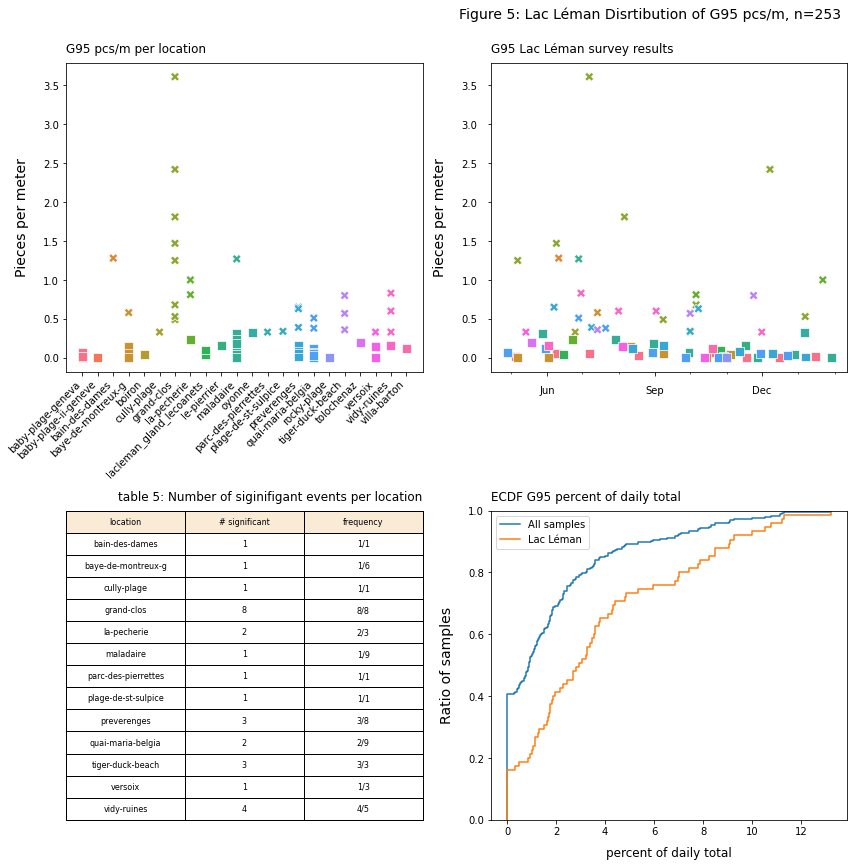

In [20]:
fig, axs = plt.subplots(2,2, figsize=(12,12))

# results grouped by beach
ax = sns.scatterplot(data=lemang112, x='location',  y='pcs_m', style='significant', markers={True:'X', False:'s'}, hue='location', marker="s", s=80, palette='husl', ax=axs[0,0])
ax.xaxis.set_tick_params(rotation=45)
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")
ax.set_xlabel("")
ax.get_legend().remove()
ax.set_title(F"{code} pcs/m per location", **title_k)
ax.set_ylabel("Pieces per meter", **ylab_k)

# results by date
ax2 = sns.scatterplot(data=lemang112, x='date', y='pcs_m', hue='location', style='significant',s=80, palette='husl', markers={True:'X', False:'s'},ax=axs[0,1])
ax2.set_title(F"{code} Lac Léman survey results", **title_k)
ax2.xaxis.set_minor_locator(days)
ax2.xaxis.set_major_formatter(mths_fmt)
ax2.xaxis.set_major_locator(months)
ax2.tick_params(which='major', pad=10)
ax2.set_xlabel("")
ax2.set_ylabel("Pieces per meter", **ylab_k)
ax2.get_legend().remove()

# table of significant events
ax3 = axs[1,0].add_table(mpl.table.table(cellText=leman90.values, colLabels=leman90.columns,colColours=['antiquewhite' for col in leman90.columns], ax=axs[1,0], **tablecenter_k))
ax1.set_fontsize(12)
axs[1,0].grid(False)
axs[1,0].spines["top"].set_visible(False)
axs[1,0].spines["right"].set_visible(False)
axs[1,0].spines["bottom"].set_visible(False)
axs[1,0].spines["left"].set_visible(False)
axs[1,0].tick_params(**tabtickp_k)
axs[1,0].set_title(F"table 5: Number of siginifigant events per location", **titler_k)

# to be decided
ax4 = sns.ecdfplot(data=g112Df, x='p_total',label='All samples', ax=axs[1,1])
ax4 = sns.ecdfplot(data=g112Df[g112Df.water_name == lake], x='p_total', label=lake,  ax=axs[1,1])
ax4.set_title(F"ECDF {code} percent of daily total", **title_k)
ax4.set_xlabel("percent of daily total", **xlab_k)
ax4.set_ylabel("Ratio of samples", **ylab_k)
labels, handles = ax4.get_legend_handles_labels()
ax4.legend(labels, handles)


plt.suptitle(F"Figure 5: Lac Léman Disrtibution of {code} pcs/m, n={len(g112Dt)}", x=.98, y=1, ha='right', fontsize=(14))


plt.tight_layout()
figfivefile = F"{project_directory}/figurefive.jpg"
files_generated.append(figfivefile)
plt.savefig(figfivefile, dpi=300)
plt.show()
plt.close()

### <span style="color:#1e90ff">Use and distribution</span>
(map 3).

In [21]:
# get the beaches for the lake in question
lemanbeaches =  dfBeaches.loc[dfBeaches.water_name == lake].copy()

# find the ones that have zero for the code quantity or pcs_m:
noGpibeaches = lemanbeaches.loc[lemanbeaches.index.isin(noGpi.location.unique())].copy()

# make a map of the location and the median pcs_m for that location
median_map = g112Df.groupby('location').pcs_m.median().copy()

# map location of no gpi to the median value in g112Df:
noGpibeaches['pcs_m'] = noGpibeaches.index.map(lambda x: median_map[x])

# get the ones that have greater than zero for the code:
gpbeaches = lemanbeaches.loc[lemanbeaches.index.isin(hasGpi.location.unique())].copy()

# map location of gpbeaches to the median value in g112Df:
gpbeaches['pcs_m'] = gpbeaches.index.map(lambda x: median_map[x])

gpsbeaches = lemanbeaches.loc[lemanbeaches.index.isin(p_dt90_s.location.unique())].copy()
gpsbeaches['pcs_m'] = gpsbeaches.index.map(lambda x: median_map[x])

# make geodata frames
gbeaches = gpd.GeoDataFrame(noGpibeaches, crs='EPSG:4326', geometry=gpd.points_from_xy(noGpibeaches.longitude, noGpibeaches.latitude))
gpibeaches = gpd.GeoDataFrame(gpbeaches, crs='EPSG:4326', geometry=gpd.points_from_xy(gpbeaches.longitude, gpbeaches.latitude))
gpsigbeaches = gpd.GeoDataFrame(gpsbeaches, crs='EPSG:4326', geometry=gpd.points_from_xy(gpsbeaches.longitude, gpsbeaches.latitude))

# get shape files 
leman_com = gpd.read_file('resources/shapes/leman_communesx.shp')
leman_filled = gpd.read_file('resources/shapes/leman_filledx.shp')
leman_ints = gpd.read_file('resources/shapes/leman_intersectsx.shp')

# if you have distribution points or user points load them here:
# gpi_sp = gpd.read_file('resources/shapes/gpi_spointsx.shp')

gdbeaches = gbeaches.to_crs(leman_ints.crs)
gpibeaches = gpibeaches.to_crs(leman_ints.crs)
gpsigbeaches = gpsigbeaches.to_crs(leman_ints.crs)

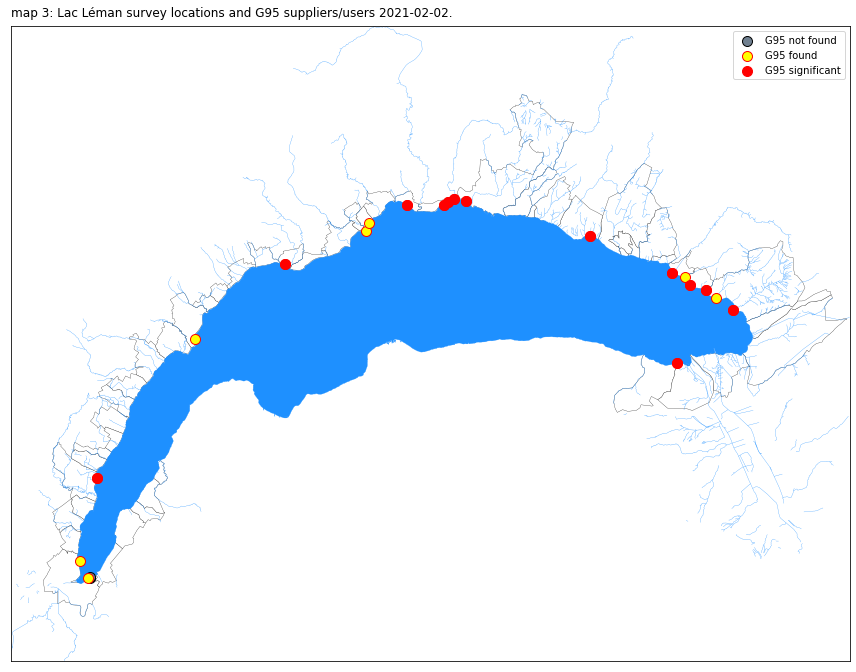

In [22]:

fig, axs = plt.subplots(figsize=(12,12))
axs.set_aspect('equal')

# plot the data frames
leman_ints.plot(ax=axs, zorder=1, color='dodgerblue', linewidth=0.26)
leman_filled.plot(ax=axs, zorder=2, color='dodgerblue', edgecolor='dodgerblue', label='riparian coumminities', linewidth=0.26)
leman_com.plot(ax=axs, zorder=0,  color='white', edgecolor='black', linewidth=0.26)
gdbeaches.plot(ax=axs, zorder=3, color='slategray', edgecolor='black',marker='o', label=F"{code} not found", markersize=markerSize)
gpibeaches.plot(ax=axs, zorder=4, color='yellow', edgecolor='red',marker='o', label=F"{code} found", markersize=markerSize)
gpsigbeaches.plot(ax=axs, zorder=5, color='red', edgecolor='red',marker='o', label=F"{code} significant", markersize=markerSize)

# these are distribution or user points, they are on top:
# gpi_sp.plot(ax=axs, zorder=6, color='red', edgecolor='red',marker='x', label=F"{code} supplier/user", markersize=markerSize) 


# set min max
minx, miny, maxx, maxy = leman_ints.total_bounds
axs.set_xticks([])
axs.set_yticks([])
axs.set_title(F"map 3: {lake} survey locations and {code} suppliers/users {end_date}.", **title_k)
axs.set_xlim(minx, maxx)
axs.set_ylim(miny, maxy)

# do work on legend if need
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)

plt.tight_layout()

mapthreefile = F"{project_directory}/mapthree.jpg"
files_generated.append(mapthreefile)
plt.savefig(mapthreefile, dpi=300)

plt.show()
plt.close()

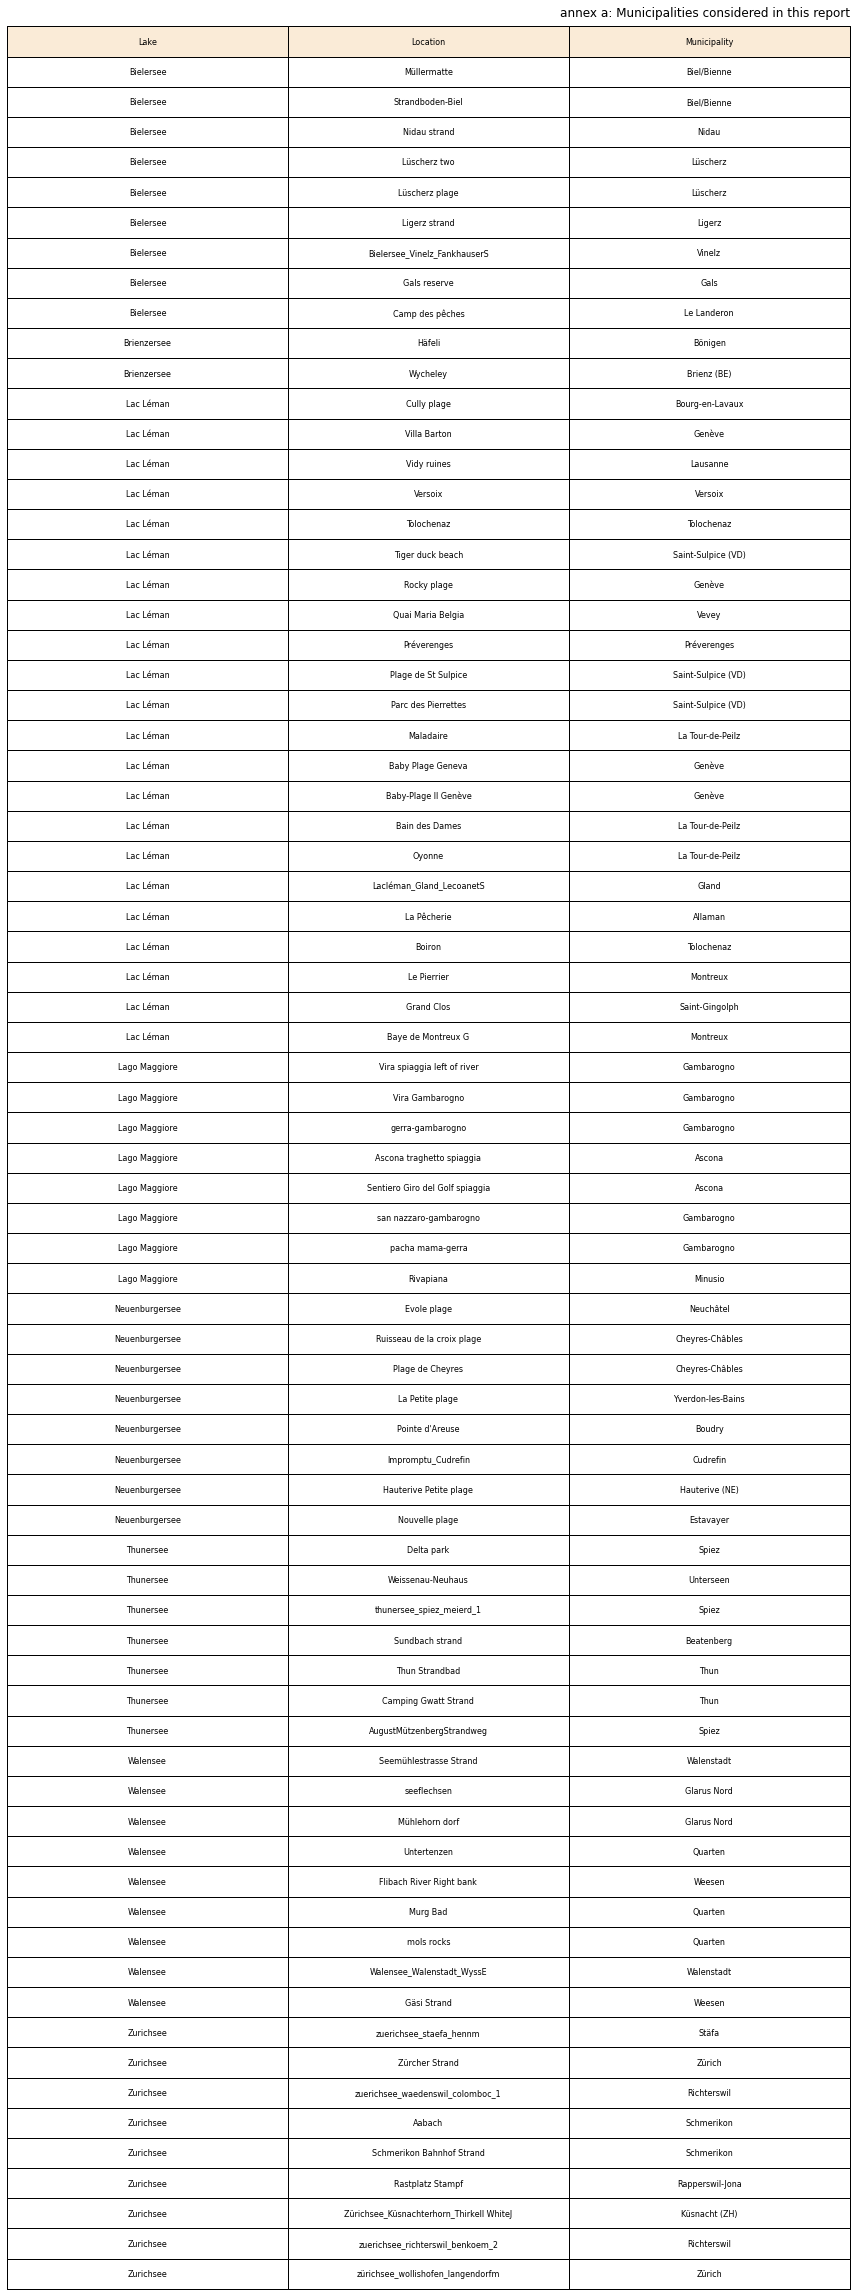

In [23]:
# display the beach, the lake and the name of each municipality
# considered in this report

data = beaches[['water_name', 'location', 'city']].sort_values(by='water_name')
data.rename(columns={'water_name':'Lake', 'location':'Location','city':'Municipality'}, inplace=True)
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center', fontsize=14)


fig, ax = plt.subplots(figsize=(12,32))
ax1= ax.add_table(mpl.table.table(cellText=data.values, colLabels=data.columns,colColours=['antiquewhite' for col in data.columns], ax=ax, **tablecenter_k))
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(**tabtickp_k)
ax.set_title(F"annex a: Municipalities considered in this report", **titler_k)
plt.tight_layout()
plt.show()

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch

In [24]:
def css_styling():
    styles = open(F"{project_directory}/custom.css").read()
    return HTML(styles)
css_styling()